In [1]:
import logging
import numpy as np
import pandas as pd
root = logging.getLogger()
root.addHandler(logging.StreamHandler())
import datetime
%matplotlib inline
from shapely.prepared import prep
from shapely import speedups
speedups.enable()

In [3]:
import pandas as pd
important_columns1 = ['species', 'dateidentified', 'eventdate', 'basisofrecord', 'decimallatitude','decimallongitude', 'day', 'month', 'year' ]
result_with_lat_long = pd.DataFrame(columns=important_columns1)
counter = 0
for df in pd.read_msgpack("../data/fish/selection/merged.msg", iterator=True):
    counter += 1
    if (counter%100==0):
        print("%s Processing.. %s " % (datetime.datetime.now().time().isoformat(), counter))
    if "decimallatitude" in df.columns.tolist() and "decimallongitude" in df.columns.tolist():
        common_columns = list(set(important_columns1).intersection(set(df.columns.tolist())))
        result_with_lat_long = result_with_lat_long.append(df[common_columns], ignore_index=True)
      

15:04:05.390324 Processing.. 100 
15:04:17.992654 Processing.. 200 
15:04:33.019456 Processing.. 300 
15:04:51.353167 Processing.. 400 
15:05:11.014846 Processing.. 500 
15:05:32.764214 Processing.. 600 
15:05:56.665404 Processing.. 700 
15:06:23.198995 Processing.. 800 
15:06:51.932699 Processing.. 900 
15:07:26.564767 Processing.. 1000 
15:08:03.810959 Processing.. 1100 
15:08:47.837072 Processing.. 1200 
15:09:31.719969 Processing.. 1300 
15:10:18.034893 Processing.. 1400 
15:11:12.971453 Processing.. 1500 
15:12:08.266557 Processing.. 1600 
15:13:10.106589 Processing.. 1700 
15:14:13.539186 Processing.. 1800 
15:15:17.949457 Processing.. 1900 
15:16:26.108047 Processing.. 2000 
15:17:40.069562 Processing.. 2100 
15:19:08.791963 Processing.. 2200 
15:20:36.307465 Processing.. 2300 
15:22:18.219172 Processing.. 2400 
15:23:52.060455 Processing.. 2500 
15:25:36.458143 Processing.. 2600 
15:27:14.736542 Processing.. 2700 
15:28:38.109453 Processing.. 2800 
15:30:07.359079 Processing.. 

## 1. Collect and filter all observations

### Recrods with latitude/longitude

In [4]:
result_with_lat_long = result_with_lat_long[result_with_lat_long.decimallatitude.notnull() & result_with_lat_long.decimallongitude.notnull()]

### How many unique species have occurrence records with latitude/longitude?

In [5]:
result_with_lat_long['species'].unique().size

5242

Best to take into account all observations which **have either "year" or "eventdate" present. (or both)** Let's group them by species name, and count the number of observation records.

In [6]:
grouped_lat_long_year_or_eventdate = pd.DataFrame()
grouped_lat_long_year_or_eventdate['count'] = result_with_lat_long[result_with_lat_long.eventdate.notnull() | result_with_lat_long.year.notnull()].groupby(['species']).apply(lambda x: x['species'].count())
grouped_lat_long_year_or_eventdate.head(10) # peak at the top 10 only

,count
species,
Aaptosyax grypus,2
Aborichthys elongatus,1
Abramis brama,114212
Acantharchus pomotis,477
Acanthobrama centisquama,1
Acanthobrama lissneri,58
Acanthobrama marmid,18
Acanthobrama telavivensis,39
Acanthobrama terraesanctae,11


### How many unique species HAVE records with latitude/longitude, AND date of event (at least year)

In [7]:
result_with_lat_long['species'].unique().size

5242

### How many unique species with latitude/longitude, AND event date after 1990?

In [8]:
year_or_eventdate_1990 = result_with_lat_long[['species', 'year', 'eventdate', 'basisofrecord', 'decimallatitude', 'decimallongitude']][(result_with_lat_long.year>1990) | (result_with_lat_long.eventdate>"1990")]

grouped_year_or_eventdate_1990 = pd.DataFrame()
grouped_year_or_eventdate_1990['numobservations'] = year_or_eventdate_1990.groupby(['species']).apply(lambda x: x['species'].count())
grouped_year_or_eventdate_1990.shape[0]

4036

In [9]:
year_or_eventdate_1990.basisofrecord.unique()

array(['PRESERVED_SPECIMEN', 'UNKNOWN', 'HUMAN_OBSERVATION', 'OBSERVATION',
       'MACHINE_OBSERVATION', 'LITERATURE', 'MATERIAL_SAMPLE',
       'LIVING_SPECIMEN', 'FOSSIL_SPECIMEN'], dtype=object)

I guess we should keep only observations of type 'OBSERVATION', 'MACHINE_OBSERVATION' and 'HUMAN_OBSERVATION'?

In [10]:
final_selection = year_or_eventdate_1990[(year_or_eventdate_1990.basisofrecord=='OBSERVATION') | (year_or_eventdate_1990.basisofrecord=='HUMAN_OBSERVATION') | (year_or_eventdate_1990.basisofrecord=='MACHINE_OBSERVATION')]

In [11]:
final_selection.species.unique().shape

(1001,)

In [12]:
final_selection

,species,year,eventdate,basisofrecord,decimallatitude,decimallongitude
399,Haplochromis elegans,2007.0,2007-01-29T23:00:00.000+0000,HUMAN_OBSERVATION,0.05810,30.15430
400,Haplochromis elegans,2007.0,2007-01-27T23:00:00.000+0000,HUMAN_OBSERVATION,-0.18930,29.94970
401,Haplochromis elegans,2007.0,2007-01-28T23:00:00.000+0000,HUMAN_OBSERVATION,0.05620,30.07970
402,Haplochromis elegans,2007.0,2007-01-31T23:00:00.000+0000,HUMAN_OBSERVATION,-0.08050,30.18710
403,Haplochromis elegans,2006.0,2006-11-21T23:00:00.000+0000,HUMAN_OBSERVATION,0.05670,30.14480
404,Haplochromis elegans,2006.0,2006-11-21T23:00:00.000+0000,HUMAN_OBSERVATION,0.05670,30.14480
561,Cirrhinus molitorella,2013.0,2013-10-12T17:13:31.000+0000,HUMAN_OBSERVATION,40.41930,-79.92587
593,Cirrhinus molitorella,1990.0,1990-06-26T22:00:00.000+0000,OBSERVATION,23.18000,120.35000
1497,Nannocharax macropterus,2015.0,2015-05-03T22:00:00.000+0000,HUMAN_OBSERVATION,-15.56737,23.28333
1589,Nannocharax macropterus,2000.0,2000-06-07T22:00:00.000+0000,HUMAN_OBSERVATION,-18.27400,21.78700


In [13]:
from iSDM.species import GBIFSpecies

In [14]:
all_species = GBIFSpecies(name_species='All')

Enabled Shapely speedups for performance.


In [15]:
all_species.set_data(final_selection)

In [16]:
all_species.get_data().species.unique().shape # these many different species

(1001,)

In [17]:
all_species.get_data().shape[0] # 1939675? this many observations satisfying our criteria (after 1990, with the correct observation type)

1939676

In [18]:
year_or_eventdate_1990.shape[0] # total number, before filtering out observations that match our criteria

2349853

In [19]:
all_species.geometrize()

Data geometrized: converted into GeoPandas dataframe.
Points with NaN coordinates ignored. 


In [20]:
all_species.get_data().species.unique().shape

(1001,)

In [22]:
final_observations = all_species.get_data()[['species', 'year','eventdate', 'basisofrecord','geometry']]

In [32]:
final_observations.to_file("../data/bias_grid/final_observations", driver="ESRI Shapefile")

In [21]:
import gc
gc.collect()

162

In [2]:
from geopandas import GeoDataFrame
final_observations = GeoDataFrame.from_file("../data/bias_grid/final_observations/")

In [4]:
final_observations.head()

,basisofrec,eventdate,geometry,species,year
0,HUMAN_OBSERVATION,2007-01-29T23:00:00.000+0000,POINT (30.1543 0.0581),Haplochromis elegans,2007.0
1,HUMAN_OBSERVATION,2007-01-27T23:00:00.000+0000,POINT (29.9497 -0.1893),Haplochromis elegans,2007.0
2,HUMAN_OBSERVATION,2007-01-28T23:00:00.000+0000,POINT (30.0797 0.0562),Haplochromis elegans,2007.0
3,HUMAN_OBSERVATION,2007-01-31T23:00:00.000+0000,POINT (30.1871 -0.0805),Haplochromis elegans,2007.0
4,HUMAN_OBSERVATION,2006-11-21T23:00:00.000+0000,POINT (30.1448 0.0567),Haplochromis elegans,2006.0


## 2. Create a bias grid at a resolution of 5arcmin (for the moment it's just counts of observations per pixel)

5 arcmin = 5/60 pixel = 0.083333333 => 'height': 2160, 'width': 4320 for a global map

(180/0.083333333) ~ 2160             
(360/0.083333333) ~ 4320

Generate 2D array and use it as a basis for bias grid.

In [5]:
x_min, y_min, x_max, y_max = -180, -90, 180, 90
pixel_size = 0.0083333333 # changed from 0.083333333 to 30arcsec
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)

In [6]:
bias_grid=np.zeros(shape=(y_res, x_res)).astype('int32')

In [7]:
def increase_pixel_value(row):
    bias_grid[np.abs(int((row.y - 90) / pixel_size)),
              np.abs(int((row.x + 180) / pixel_size))]+=1

In [8]:
here = final_observations.geometry.apply(lambda row: increase_pixel_value(row))

In [22]:
bias_grid.max()

42848

In [22]:
bias_grid.std()

MemoryError: 

In [10]:
bias_grid.sum()

1939676

In [11]:
# is the sum of the bias grid equal to the total number of observations?
bias_grid.sum() == final_observations.shape[0] 

True

In [12]:
import gc
gc.collect()

142

#### Normalize using log10?

In [13]:
# bias_grid_plus_1 = bias_grid + 1
bias_grid_log = np.log10(bias_grid + 1)
# bias_grid_log[np.isneginf(bias_grid_log)] = 0 # is this a good idea, setting to 0? log10(0) = infinity otherwise
bias_grid_log.max()

4.6319406909138356

In [12]:
bias_grid_log.min()

0.0

In [13]:
bias_grid_log.std()

MemoryError: 

#### Standardize?

In [ ]:
bias_grid_standardized = (bias_grid - bias_grid.mean()) / bias_grid.std()
bias_grid_standardized.max()

In [ ]:
bias_grid_standardized.min()

In [ ]:
bias_grid_standardized.std()

#### Min-Max scaling?

In [ ]:
bias_grid_minmax_scale = (bias_grid - bias_grid.min()) / (bias_grid.max() - bias_grid.min())
bias_grid_minmax_scale.max()

In [ ]:
bias_grid_minmax_scale.min()

In [ ]:
bias_grid_minmax_scale.std()

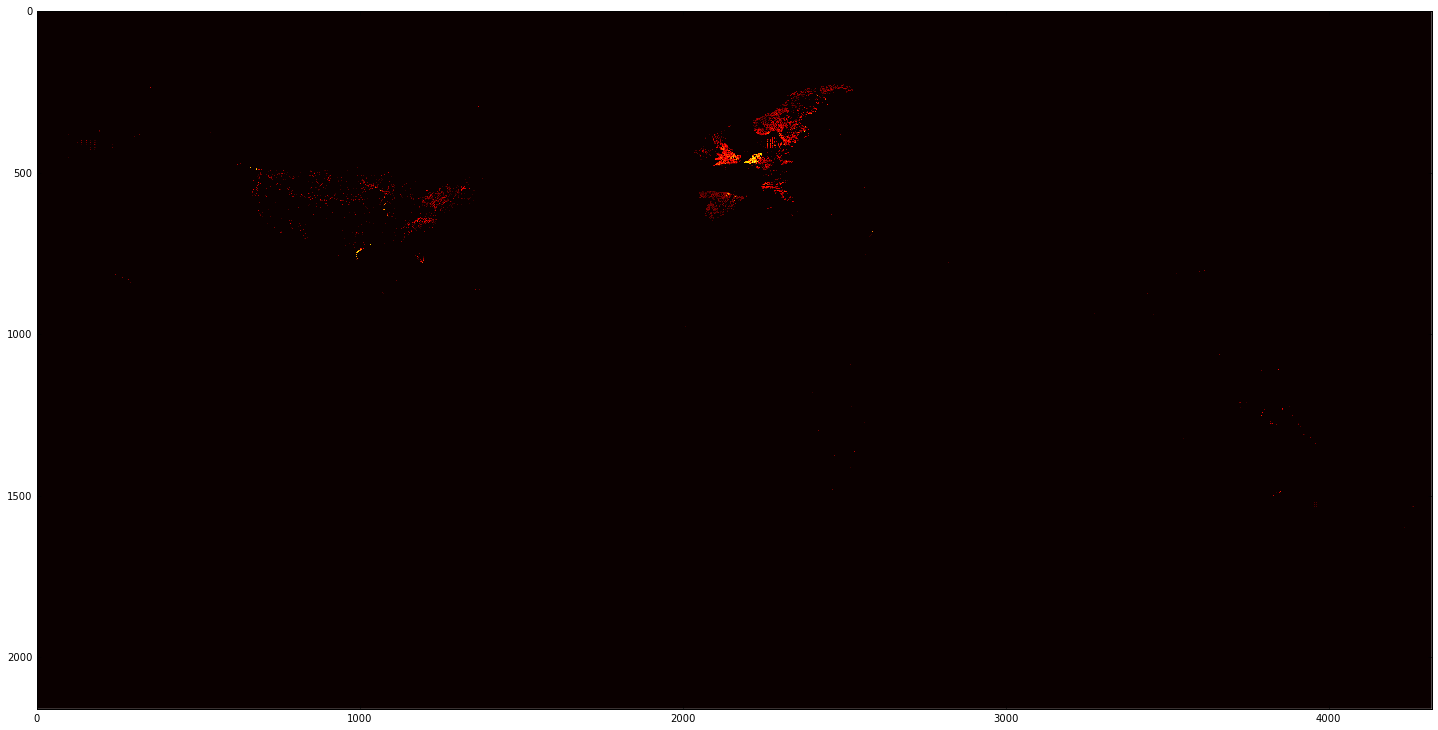

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,20))
plt.imshow(bias_grid_log, cmap="hot", interpolation="none")

In [17]:
import pickle
pickle.dump(bias_grid, open("../data/bias_grid/bias_grid_30arcsec.pkl", "wb"))

MemoryError: 

In [ ]:
np.count_nonzero(bias_grid)

In [ ]:
np.product(bias_grid.shape)

In [49]:
41881/9331200

0.004488275891632373

In [26]:
bias_grid.shape

(2160, 4320)

In [21]:
import rasterio
from rasterio.transform import Affine
x_min, y_min, x_max, y_max = -180, -90, 180, 90
pixel_size = 0.083333333
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)
crs = {'init': "EPSG:4326"}
transform = Affine.translation(x_min, y_max) * Affine.scale(pixel_size, -pixel_size)

In [37]:
with rasterio.open("../data/bias_grid/bias_grid_minmax_scale.tif", 'w', driver='GTiff', width=x_res, height=y_res,
                   count=1,
                   dtype=np.uint16,
                   nodata=0,
                   transform=transform,
                   crs=crs) as out:
    out.write(bias_grid_minmax_scale.astype(np.uint16), indexes=1)
    out.close()

In [27]:
pixel_size

0.083333333

In [39]:
bias_grid_minmax_scale.std()

0.00063270764269115793

In [19]:
bias_grid_log.shape

(21600, 43200)

In [20]:
import pickle
pickle.dump(bias_grid_log, open("../data/bias_grid/bias_grid_log_30arcsec.pkl", "wb"), protocol=4)

MemoryError: 

In [43]:
pickle.dump(bias_grid_standardized, open("../data/bias_grid/bias_grid_standardized.pkl", "wb"))

In [44]:
pickle.dump(bias_grid_minmax_scale, open("../data/bias_grid/bias_grid_minmax_scale.pkl", "wb"))

## numpy array memory map

In [26]:
# bias_grid_mm=np.zeros(shape=(y_res, x_res)).astype('int32')
bias_grid_mm = np.memmap("../data/bias_grid/bias_grid_mm.dat", dtype='int32', mode='w+', shape=(y_res,x_res))

In [27]:
def increase_pixel_value(row):
    bias_grid_mm[np.abs(int((row.y - 90) / pixel_size)),
              np.abs(int((row.x + 180) / pixel_size))]+=1

In [28]:
here = final_observations.geometry.apply(lambda row: increase_pixel_value(row))

In [33]:
bias_grid_mm.flush()

In [35]:
bias_grid_mm.max()

memmap(42848, dtype=int32)

In [36]:
bias_grid_mm.std()

memmap(1.8395193632862339)

In [40]:
del bias_grid_mm

In [41]:
gc.collect()

87

In [42]:
fpr = np.memmap("../data/bias_grid/bias_grid_mm.dat", dtype='int32', mode='r', shape=(y_res, x_res))

In [44]:
fpr.max()

memmap(42848, dtype=int32)

In [47]:
fpr.flags.writeable

False

### Can read any tif file as memory map??

In [81]:
anything = np.memmap("/home/daniela/git/iSDM/data/GLWD/downscaled/original_corrected.tif", dtype='uint8',  mode='r', shape=(y_res,x_res))

In [82]:
np.unique(anything)

memmap([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

In [67]:
type(anything)

numpy.core.memmap.memmap

In [78]:
gc.collect()

3190

In [77]:
del anything

In [101]:
some_data = np.memmap("../data/bias_grid/some_data.tif", dtype='float64', mode='w+', shape=(y_res,x_res))

In [97]:
type(some_data)

numpy.core.memmap.memmap

In [93]:
some_data.flags.writeable

True

In [99]:
isinstance(some_data, np.ndarray) 

True

In [106]:
some_data.shape

(21600, 43200)

In [109]:
some_data[:,:] = 1

In [110]:
some_data._mmap

In [112]:
some_data

memmap([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])